# Промышленность Оптимизация производственных расходов металлургического комбината 

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

## Цель проекта

Предсказать конечную температуру полного цикла с ошибкой MAE меньше 6.8 на тексте. Расчитать метрику R квадрат. Разрешается брать только начальную темпрературу. Обучение модели с кросс-валидацией. Подбор для одной модели гиперпараметров. Использовать как признак можно только первую температуру.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Исходные данные

### Импорт библитек

In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [288]:
RANDOM_STATE = 22052023

### Откроем файл с данными и изучем общую информацию

In [289]:
# Загрузка данных
try:
    arc = pd.read_csv("/datasets/data_arc_new.csv")
    bulk = pd.read_csv("/datasets/data_bulk_new.csv")
    bulk_time = pd.read_csv("/datasets/data_bulk_time_new.csv")
    gas = pd.read_csv("/datasets/data_gas_new.csv")
    temp = pd.read_csv("/datasets/data_temp_new.csv")
    wire = pd.read_csv("/datasets/data_wire_new.csv")
    wire_time = pd.read_csv("/datasets/data_wire_time_new.csv")
except:
    arc = pd.read_csv("https://code.s3.yandex.net/datasets/data_arc_new.csv")
    bulk = pd.read_csv("https://code.s3.yandex.net/datasets/data_bulk_new.csv")
    bulk_time = pd.read_csv(
        "https://code.s3.yandex.net/datasets/data_bulk_time_new.csv"
    )
    gas = pd.read_csv("https://code.s3.yandex.net/datasets/data_gas_new.csv")
    temp = pd.read_csv("https://code.s3.yandex.net/datasets/data_temp_new.csv")
    wire = pd.read_csv("https://code.s3.yandex.net/datasets/data_wire_new.csv")
    wire_time = pd.read_csv(
        "https://code.s3.yandex.net/datasets/data_wire_time_new.csv"
    )

In [290]:
# Проверка данных
dataframes = [arc, bulk, bulk_time, gas, temp, wire, wire_time]
names = ["arc", "bulk", "bulk_time", "gas", "temp", "wire", "wire_time"]

for df, name in zip(dataframes, names):
    print(f"--- {name} ---")
    print(df.head())
    print(df.info())
    print(df.isna().sum())
    print()

--- arc ---
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Промежуточные выводы

Мы загрузили семь файлов с данными. Количество строк в файлах различается. Вос всех файлах есть пропуски данных. Каждый файл содержит столбец key, возможно его можно будет использовать для объединения таблиц.

## Исследовательский анализ данных и предобраотка

### Данные об электродах

In [291]:
arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [292]:
# Проверим данные на дубликаты:
arc.duplicated().sum()

0

Активная мощность и реактивная мощность отличается в партиях. Будемм рассчитывать полную мощность

In [293]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [294]:
# Пропусков в этом файле нет. Приведем даты к формату Datetime:
arc["Начало нагрева дугой"] = pd.to_datetime(arc["Начало нагрева дугой"])
arc["Конец нагрева дугой"] = pd.to_datetime(arc["Конец нагрева дугой"])

In [295]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [296]:
# есть отрицательное значение в реактивной мощности – нужно удалить этот ключ целиком(требование заказчика)
negative_power_keys = arc[arc["Реактивная мощность"] < 0]["key"]
print(negative_power_keys)
# Удалить строки с отрицательной реактивной мощностью
arc = arc[~arc["key"].isin(negative_power_keys)]

9780    2116
Name: key, dtype: int64


In [297]:
# Найти ключи с одним замером
one_measurement_keys = arc["key"].value_counts()[arc["key"].value_counts() == 1].index
print(one_measurement_keys)
# Удалить строки с одним замером
arc = arc[~arc["key"].isin(one_measurement_keys)]

Int64Index([1268, 2841,  343, 3112,  614, 1535, 1988, 2738,  943, 1281, 2112,
             732, 1974,  246,   49,  556, 1449, 1914, 3026,  269, 2795, 1169,
             661, 1911, 2582,  530,  977,  247,  248, 2194, 1766, 1369, 2179,
            1568,  112, 2472, 2025, 3059, 1615],
           dtype='int64')


In [298]:
# Высчитаем время нагрева и полную мощность.
arc["time"] = (arc["Конец нагрева дугой"] - arc["Начало нагрева дугой"]).dt.total_seconds()
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157.0
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180.0
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184.0
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57.0


In [299]:
# Полная мощность рассчитывается как квадратный корень из суммы квадратов активной и реактивной мощностей.
arc["capacity"] = (
    arc["Активная мощность"] ** 2 + arc["Реактивная мощность"] ** 2
) ** 0.5
arc["power"] = arc["capacity"] * arc["time"]
arc["act_power"] = arc["Активная мощность"] * arc["time"]
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time,capacity,power,act_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252,128.335684
...,...,...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157.0,0.532085,83.537345,69.038395
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180.0,0.792429,142.637202,116.369640
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184.0,1.293389,237.983620,191.309584
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57.0,0.641792,36.582120,30.225219


In [300]:
# Сгруппируем данные по партиям и для каждой партии высчитаем суммарное потребление энергии на основе полной мощности (power) и активной мощности (act_power):
arc = (arc.groupby("key").agg({"time": sum, "power": sum, "act_power": sum}).reset_index())
arc.set_index("key", inplace=True)
arc

,time,power,act_power
key,,,
1,1098.0,770.282114,628.616930
2,811.0,481.760005,395.281800
3,655.0,722.837668,581.774624
4,741.0,683.455597,543.710274
5,869.0,512.169934,412.180480
...,...,...,...
3237,909.0,630.503534,493.152191
3238,546.0,286.052252,229.390861
3239,1216.0,941.538764,751.674870


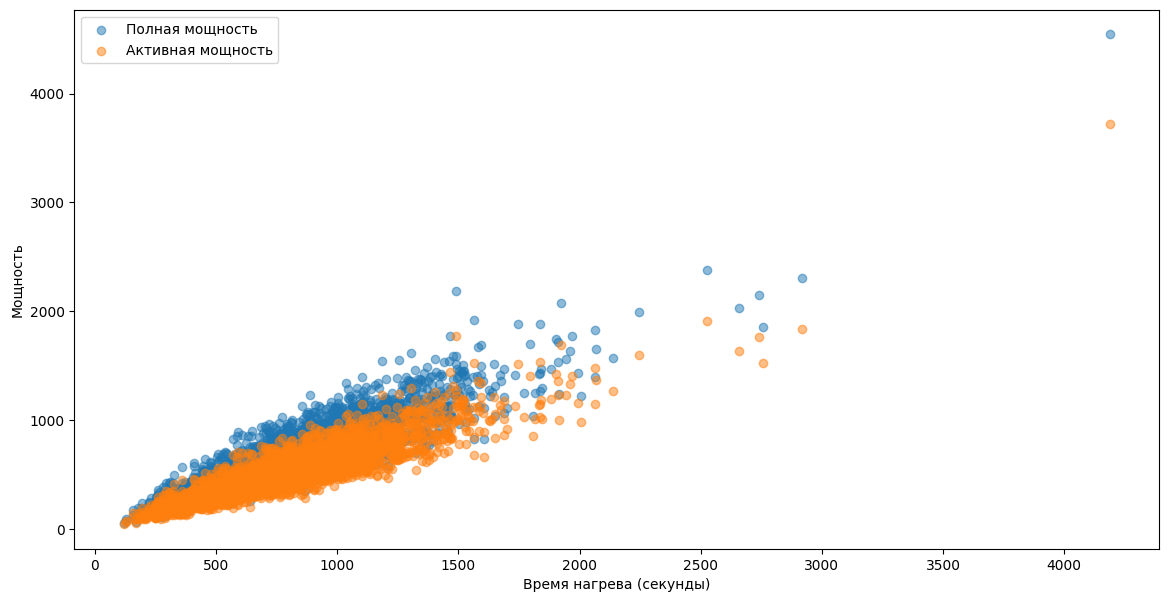

In [301]:
# График зависимости времени от мощности и полной мощности

plt.figure(figsize=(14, 7))

plt.scatter(arc["time"], arc["power"], alpha=0.5, label="Полная мощность")
plt.scatter(arc["time"], arc["act_power"], alpha=0.5, label="Активная мощность")
plt.xlabel("Время нагрева (секунды)")
plt.ylabel("Мощность")
plt.legend()

plt.show()

#### Обобщение по arc

1. Привели колонки  временем к формату datatime
2. Есть отрицательное значение мощности - ключ удалили целиком(требование заказчика)
3. Нашли ключи с одним замером и удалили их(требование заказчика)
4. Высчитаем время нагрева и полную мощность.
5. Сгруппировали данные по партиям и для каждой партии высчитаем суммарное потребление энергии на основе полной мощности (power) и активной мощности
6. Построили график зависимости мощности от времени. Чем больше время нагрева тем больше мощность
7. Пропуски и дубликаты отсутствуют


### Данные об объеме сыпучих и проволочных материалов, а также о времени их подачи


#### Сыпучие материалы

In [302]:
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [303]:
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [304]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [305]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [306]:
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [307]:
bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [308]:
# Проверим данные на дубликаты:
bulk.duplicated().sum()

0

In [309]:
# Проверим данные на дубликаты:
bulk_time.duplicated().sum()

0

In [310]:
# Пропуски заменим нулями:
bulk = bulk.fillna(0)
bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [311]:
# Проиндексируем по номерам партий:
bulk.set_index('key', inplace = True)
bulk.head()


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [312]:
# Проиндексируем по номерам партий:
bulk_time.set_index('key', inplace = True)
# Изменим формат времени на datime
bulk_columns = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']

for col in bulk_columns:
    bulk_time[col] = pd.to_datetime(bulk_time[col])

bulk_time.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


#### Обобщение по bulk

1. Множество пропусков. Обусловлено спецификой технологического процесса. Пропуски заменили нулями(от заказчика)
2. Отсутствуют дубликаты
3. Проиндексировали по номеру ключа
4. Привели формат времени к datetime

#### Проволочные материалы

In [313]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [314]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [315]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [316]:
wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [317]:
# Проверим данные на дубликаты:
wire.duplicated().sum()

0

In [318]:
# Проверим данные на дубликаты:
wire_time.duplicated().sum()

0

In [319]:
# Пропуски заменим нулями:
wire = wire.fillna(0)
wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [320]:
# Проиндексируем по номерам партий:
wire.set_index('key', inplace = True)
wire.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [321]:
# Проиндексируем по номерам партий:
wire_time.set_index('key', inplace = True)
# Изменим формат времени на datime
wire_columns = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']

for col in bulk_columns:
    wire_time[col] = pd.to_datetime(bulk_time[col])

wire_time.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


#### Обобщение по Wire


1. Множество пропусков. Обусловлено спецификой технологического процесса. Пропуски заменили нулями(от заказчика)
2. Отсутствуют дубликаты
3. Проиндексировали по номеру ключа
4. Привели формат времени к datetime

### Данные о температуре и продувке газом 


In [322]:
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [323]:
temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [324]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [325]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [326]:
temp.isna().sum().to_frame()


,0
key,0
Время замера,0
Температура,3427


В столбце в температурой много пропусков но заменить нечем. Мы имеем дело с промышленными данными, можно предположить, что пропуски возникли при отказах измерительного оборудования.


In [327]:
# Приведем время к формату datatime
temp['Время замера'] = pd.to_datetime(temp['Время замера'])
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [328]:
# Проверим дубликаты:
print(gas.duplicated().sum())
print(temp.duplicated().sum())

0
0


Text(0.5, 1.0, 'Boxplot')

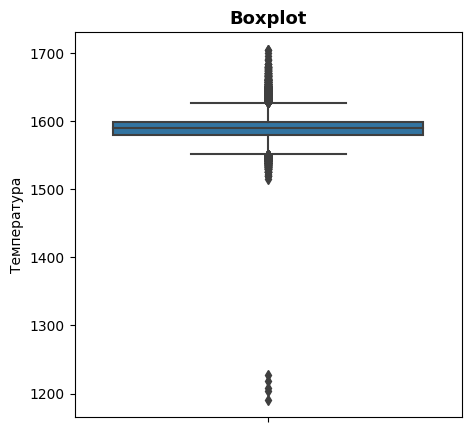

In [329]:
plt.figure(figsize=(5,5))
sns.boxplot(data=temp, y='Температура')
plt.title('Boxplot', fontsize=13, fontweight='bold')

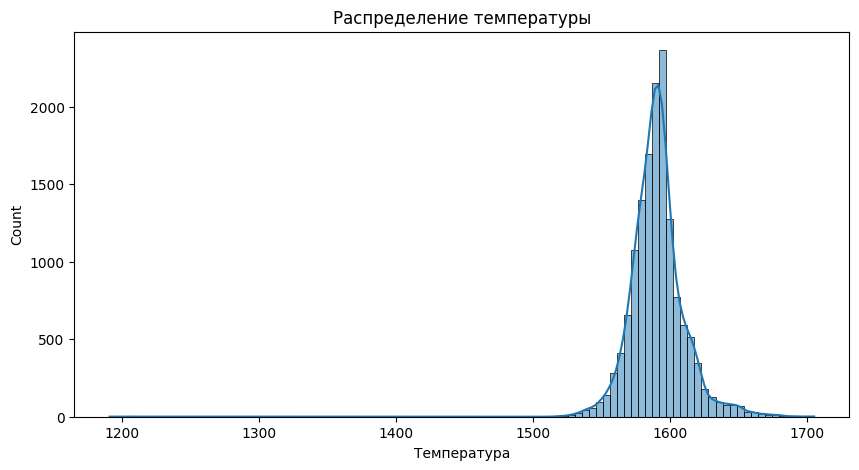

In [330]:
# Анализ распределения температуры
plt.figure(figsize=(10,5))
sns.histplot(temp['Температура'], bins=100, kde=True)
plt.title('Распределение температуры')
plt.show()

In [331]:
# есть низкие температуры  < 1500 – нужно удалить из объединенной выборки(требование заказчика)
temp = temp[temp['Температура'] >= 1500]
# Затем для удаления партий с одним замером, мы сначала найдем такие партии, а затем удалим их:
# Находим партии с одним замером
one_measurement_keys = temp['key'].value_counts()
one_measurement_keys = one_measurement_keys[one_measurement_keys == 1].index
print(one_measurement_keys)
# Удаляем эти партии из temp
temp = temp[~temp['key'].isin(one_measurement_keys)]
print(temp.head(6))

Int64Index([2993, 2992, 2991, 2990, 2995, 2989, 2988, 2987, 2994, 2999,
            ...
            2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 3241],
           dtype='int64', length=740)
   key        Время замера  Температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0
5    1 2019-05-03 11:30:38       1613.0


In [332]:
# Для агрегирования данных по первой и последней температуре для каждого ключа (или партии), мы можете использовать следующий подход:
# Сначала сортируем данные по времени замера
temp.sort_values(by=['key', 'Время замера'], inplace=True)

# Затем группируем данные по ключу и выбираем первую и последнюю температуру для каждого ключа
first_temp = temp.groupby('key')['Температура'].first()
last_temp = temp.groupby('key')['Температура'].last()

# Создаем новый DataFrame с двумя столбцами: первой и последней температурой
aggregated_temp = pd.DataFrame({'first_temp': first_temp, 'last_temp': last_temp})
aggregated_temp

,first_temp,last_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


<Axes: xlabel='Время замера', ylabel='Count'>

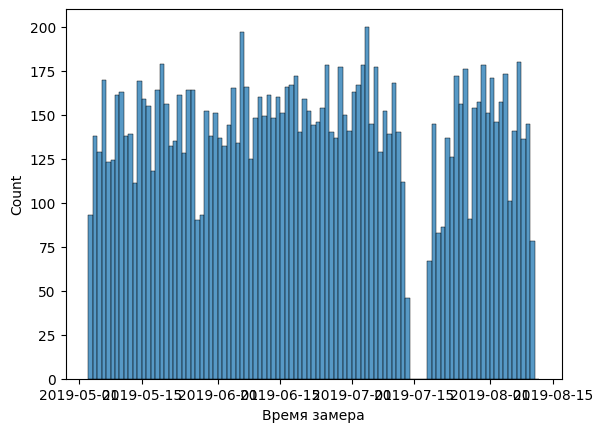

In [333]:
sns.histplot(data=temp, x='Время замера', discrete=True)


### Вывод по исследовательскому анализу данных 

## Подробный план работы

## вопросы

### Проверим дубликаты

### Предобработка данных

#### Рассмотрим корреляцию данных. Зависимость параметров

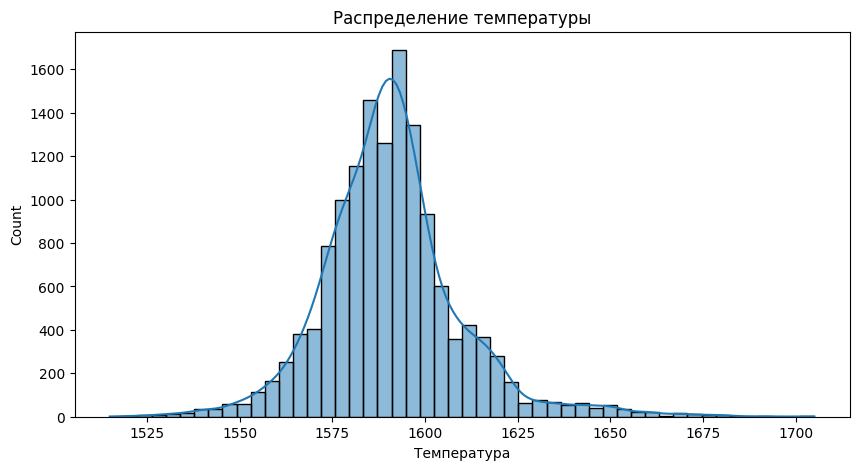

In [334]:
# Анализ распределения температуры
plt.figure(figsize=(10, 5))
sns.histplot(temp["Температура"], bins=50, kde=True)
plt.title("Распределение температуры")
plt.show()

In [335]:
arc

,time,power,act_power
key,,,
1,1098.0,770.282114,628.616930
2,811.0,481.760005,395.281800
3,655.0,722.837668,581.774624
4,741.0,683.455597,543.710274
5,869.0,512.169934,412.180480
...,...,...,...
3237,909.0,630.503534,493.152191
3238,546.0,286.052252,229.390861
3239,1216.0,941.538764,751.674870


### Исследовательский анализ данных

### Сформулируем выводы


## Основная часть

### Обработка данных


#### Промежуточные выводы

### Объединения датасетов. После объединения нужно вывести графики распределения признаков


#### Для итогового датафрейма после объединения всех таблиц выведем df.tail()

#### Промежуточные выводы

### Выбор лучшей модели

#### Промежуточные выводы

### Тестирование лучшей модели

#### Промежуточные выводы

### Итоговый вывод

## Отчет 